In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms
from torch.distributions.bernoulli import Bernoulli

In [2]:
import sys
sys.path.append('./../../')

from modules.dvae.model import DVAE
from train_utils.dvae_utils import TemperatureAnnealer
from train_utils.dvae_utils import KLDWeightAnnealer
from train_utils.dvae_utils import KLD_uniform_loss, KLD_codes_uniform_loss

from notebooks.utils import show

from datasets.mnist_loader import MNISTData

In [3]:
class Config:
    DEVICE                = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_channels           = 1
    vocab_size            = 32
    num_x2downsamples     = 2
    num_resids_downsample = 3
    num_resids_bottleneck = 4
    hidden_dim            = 256
    NUM_EPOCHS            = 60
    BATCH_SIZE            = 256
    LR                    = 0.1
    LR_gamma              = 0.1
    step_LR_milestones    = [10, 30]
    temp_start            = 5
    temp_end              = 0.01
    temp_steps            = 100 * 30
    KLD_lambda_start      = 0
    KLD_lambda_end        = 6
    KLD_lambda_steps      = 100 * 20
    
    dvae_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist56/"
    dvae_model_name       = "dvae_vocab32_img56"
    
    mnist_type            = "classic_56"
    root_img_path         = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"

CONFIG = Config()

In [4]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

temp_annealer = TemperatureAnnealer(
    start_temp=CONFIG.temp_start,
    end_temp=CONFIG.temp_end,
    n_steps=CONFIG.temp_steps)

kl_annealer = KLDWeightAnnealer(
    start_lambda=CONFIG.KLD_lambda_start,
    end_lambda=CONFIG.KLD_lambda_end,
    n_steps=CONFIG.KLD_lambda_steps)


In [5]:
model = DVAE(in_channels=CONFIG.in_channels,
             vocab_size=CONFIG.vocab_size,
             num_x2downsamples=CONFIG.num_x2downsamples,
             num_resids_downsample=CONFIG.num_resids_downsample,
             num_resids_bottleneck=CONFIG.num_resids_bottleneck,
             hidden_dim=CONFIG.hidden_dim)

model.train()
model.to(CONFIG.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=CONFIG.LR)
lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)


model.show_model_architecture()

DVAE architecture:

Encoder Model:
  ChangeChannels(in=1, out=64)
  DownSampleX2(in=64, out=128)
  ResidualStack(in=128, out=128, n_resid=3)
  DownSampleX2(in=128, out=256)
  ResidualStack(in=256, out=256, n_resid=3)
  ResidualStack(in=256, out=256, n_resid=4)
  DownSampleX2(in=256, out=32)


Decoder Model:
  ChangeChannels(in=32, out=256)
  ResidualStack(in=256, out=256, n_resid=4)
  DownSampleX2(in=256, out=128)
  ResidualStack(in=128, out=128, n_resid=3)
  DownSampleX2(in=128, out=64)
  ResidualStack(in=64, out=64, n_resid=3)
  ChangeChannels(in=64, out=1)




Device in use: cuda
Epoch: 0 Iter: 39 Loss: 0.063298 Recon Loss 0.06252 KL: 0.007778 N codes used: 32
Epoch: 0 Iter: 79 Loss: 0.054913 Recon Loss 0.054535 KL: 0.003788 N codes used: 32
Epoch: 0 Iter: 119 Loss: 0.04705 Recon Loss 0.046908 KL: 0.001428 N codes used: 32
Epoch: 0 Iter: 159 Loss: 0.045698 Recon Loss 0.045331 KL: 0.003666 N codes used: 32
Epoch: 0 Iter: 199 Loss: 0.03799 Recon Loss 0.037716 KL: 0.002739 N codes used: 32
Epoch: 1 Iter: 239 Loss: 0.032799 Recon Loss 0.032591 KL: 0.002073 N codes used: 32
Epoch: 1 Iter: 279 Loss: 0.030616 Recon Loss 0.030405 KL: 0.002104 N codes used: 32
Epoch: 1 Iter: 319 Loss: 0.028987 Recon Loss 0.028768 KL: 0.002193 N codes used: 32
Epoch: 1 Iter: 359 Loss: 0.027428 Recon Loss 0.027238 KL: 0.0019 N codes used: 32
Epoch: 1 Iter: 399 Loss: 0.025612 Recon Loss 0.02536 KL: 0.002524 N codes used: 32
Epoch: 1 Iter: 439 Loss: 0.025563 Recon Loss 0.025374 KL: 0.001896 N codes used: 32
Epoch: 2 Iter: 479 Loss: 0.023418 Recon Loss 0.023207 KL: 0.0021

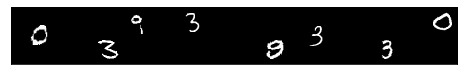

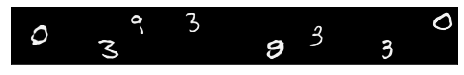

Epoch: 5 Iter: 1199 Loss: 0.019221 Recon Loss 0.018799 KL: 0.004214 N codes used: 32
Epoch: 5 Iter: 1239 Loss: 0.018606 Recon Loss 0.018299 KL: 0.003072 N codes used: 32
Epoch: 5 Iter: 1279 Loss: 0.019235 Recon Loss 0.018885 KL: 0.003501 N codes used: 32
Epoch: 5 Iter: 1319 Loss: 0.018519 Recon Loss 0.018048 KL: 0.004709 N codes used: 32
Epoch: 5 Iter: 1359 Loss: 0.018003 Recon Loss 0.017648 KL: 0.003559 N codes used: 32
Epoch: 5 Iter: 1399 Loss: 0.018347 Recon Loss 0.018 KL: 0.003465 N codes used: 32
Epoch: 6 Iter: 1439 Loss: 0.018733 Recon Loss 0.018353 KL: 0.003802 N codes used: 32
Epoch: 6 Iter: 1479 Loss: 0.018324 Recon Loss 0.017923 KL: 0.004014 N codes used: 32
Epoch: 6 Iter: 1519 Loss: 0.018185 Recon Loss 0.017749 KL: 0.004364 N codes used: 32
Epoch: 6 Iter: 1559 Loss: 0.0184 Recon Loss 0.017954 KL: 0.004468 N codes used: 32
Epoch: 6 Iter: 1599 Loss: 0.017933 Recon Loss 0.017449 KL: 0.004838 N codes used: 32
Epoch: 6 Iter: 1639 Loss: 0.018412 Recon Loss 0.01789 KL: 0.005219 N c

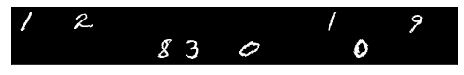

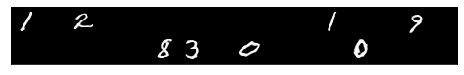

Epoch: 10 Iter: 2359 Loss: 0.019572 Recon Loss 0.017732 KL: 0.018397 N codes used: 32
Epoch: 10 Iter: 2399 Loss: 0.020918 Recon Loss 0.018777 KL: 0.02141 N codes used: 32
Epoch: 10 Iter: 2439 Loss: 0.021076 Recon Loss 0.018788 KL: 0.022888 N codes used: 32
Epoch: 10 Iter: 2479 Loss: 0.021002 Recon Loss 0.018474 KL: 0.025283 N codes used: 32
Epoch: 10 Iter: 2519 Loss: 0.022561 Recon Loss 0.019689 KL: 0.028719 N codes used: 32
Epoch: 10 Iter: 2559 Loss: 0.022445 Recon Loss 0.019375 KL: 0.030701 N codes used: 32
Epoch: 11 Iter: 2599 Loss: 0.021715 Recon Loss 0.018284 KL: 0.034317 N codes used: 32
Epoch: 11 Iter: 2639 Loss: 0.022614 Recon Loss 0.018806 KL: 0.03808 N codes used: 32
Epoch: 11 Iter: 2679 Loss: 0.022637 Recon Loss 0.018407 KL: 0.042302 N codes used: 32
Epoch: 11 Iter: 2719 Loss: 0.023804 Recon Loss 0.019226 KL: 0.045789 N codes used: 32
Epoch: 11 Iter: 2759 Loss: 0.02523 Recon Loss 0.02014 KL: 0.0509 N codes used: 32
Epoch: 11 Iter: 2799 Loss: 0.023824 Recon Loss 0.018567 KL: 

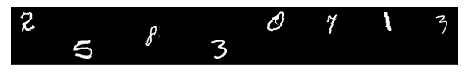

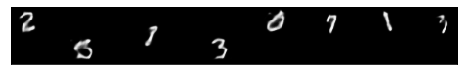

Epoch: 15 Iter: 3559 Loss: 0.043689 Recon Loss 0.034954 KL: 0.08735 N codes used: 32
Epoch: 15 Iter: 3599 Loss: 0.041882 Recon Loss 0.033083 KL: 0.087996 N codes used: 32
Epoch: 15 Iter: 3639 Loss: 0.040049 Recon Loss 0.031256 KL: 0.087935 N codes used: 32
Epoch: 15 Iter: 3679 Loss: 0.039145 Recon Loss 0.030272 KL: 0.088726 N codes used: 32
Epoch: 15 Iter: 3719 Loss: 0.039655 Recon Loss 0.031432 KL: 0.082224 N codes used: 32
Epoch: 15 Iter: 3759 Loss: 0.039326 Recon Loss 0.030539 KL: 0.087865 N codes used: 32
Epoch: 16 Iter: 3799 Loss: 0.039939 Recon Loss 0.031773 KL: 0.081664 N codes used: 32
Epoch: 16 Iter: 3839 Loss: 0.038127 Recon Loss 0.03027 KL: 0.078567 N codes used: 32
Epoch: 16 Iter: 3879 Loss: 0.040556 Recon Loss 0.032215 KL: 0.083408 N codes used: 32
Epoch: 16 Iter: 3919 Loss: 0.037884 Recon Loss 0.029818 KL: 0.080663 N codes used: 32
Epoch: 16 Iter: 3959 Loss: 0.039495 Recon Loss 0.030969 KL: 0.085261 N codes used: 32
Epoch: 17 Iter: 3999 Loss: 0.041208 Recon Loss 0.031933 

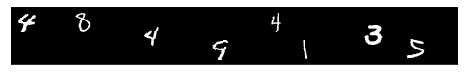

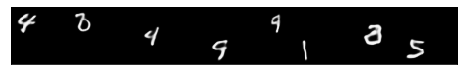

Epoch: 20 Iter: 4719 Loss: 0.034175 Recon Loss 0.026316 KL: 0.078591 N codes used: 32
Epoch: 20 Iter: 4759 Loss: 0.035066 Recon Loss 0.027146 KL: 0.079203 N codes used: 32
Epoch: 20 Iter: 4799 Loss: 0.034364 Recon Loss 0.026415 KL: 0.079492 N codes used: 32
Epoch: 20 Iter: 4839 Loss: 0.035007 Recon Loss 0.026337 KL: 0.086699 N codes used: 32
Epoch: 20 Iter: 4879 Loss: 0.034607 Recon Loss 0.026143 KL: 0.08464 N codes used: 32
Epoch: 20 Iter: 4919 Loss: 0.033827 Recon Loss 0.026066 KL: 0.077604 N codes used: 32
Epoch: 21 Iter: 4959 Loss: 0.035545 Recon Loss 0.026893 KL: 0.086518 N codes used: 32
Epoch: 21 Iter: 4999 Loss: 0.035302 Recon Loss 0.027322 KL: 0.0798 N codes used: 32
Epoch: 21 Iter: 5039 Loss: 0.035021 Recon Loss 0.02676 KL: 0.082616 N codes used: 32
Epoch: 21 Iter: 5079 Loss: 0.034406 Recon Loss 0.02622 KL: 0.081858 N codes used: 32
Epoch: 21 Iter: 5119 Loss: 0.036134 Recon Loss 0.028084 KL: 0.080501 N codes used: 32
Epoch: 21 Iter: 5159 Loss: 0.035098 Recon Loss 0.026809 KL:

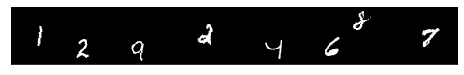

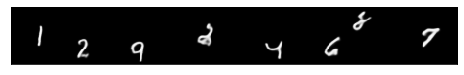

Epoch: 25 Iter: 5879 Loss: 0.039264 Recon Loss 0.030203 KL: 0.09061 N codes used: 32
Epoch: 25 Iter: 5919 Loss: 0.038777 Recon Loss 0.028585 KL: 0.101916 N codes used: 32
Epoch: 25 Iter: 5959 Loss: 0.041165 Recon Loss 0.029458 KL: 0.117079 N codes used: 32
Epoch: 25 Iter: 5999 Loss: 0.038824 Recon Loss 0.029889 KL: 0.089348 N codes used: 32
Epoch: 25 Iter: 6039 Loss: 0.036637 Recon Loss 0.028215 KL: 0.08422 N codes used: 32
Epoch: 25 Iter: 6079 Loss: 0.036447 Recon Loss 0.028313 KL: 0.08134 N codes used: 32
Epoch: 26 Iter: 6119 Loss: 0.035402 Recon Loss 0.027286 KL: 0.081158 N codes used: 32
Epoch: 26 Iter: 6159 Loss: 0.034771 Recon Loss 0.027012 KL: 0.077586 N codes used: 32
Epoch: 26 Iter: 6199 Loss: 0.036192 Recon Loss 0.027775 KL: 0.08417 N codes used: 32
Epoch: 26 Iter: 6239 Loss: 0.036363 Recon Loss 0.028843 KL: 0.0752 N codes used: 32
Epoch: 26 Iter: 6279 Loss: 0.037612 Recon Loss 0.028943 KL: 0.086694 N codes used: 32
Epoch: 26 Iter: 6319 Loss: 0.036645 Recon Loss 0.028434 KL: 

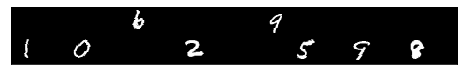

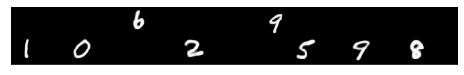

Epoch: 30 Iter: 7079 Loss: 0.032945 Recon Loss 0.024945 KL: 0.080001 N codes used: 32
Epoch: 30 Iter: 7119 Loss: 0.034259 Recon Loss 0.025846 KL: 0.084127 N codes used: 32
Epoch: 30 Iter: 7159 Loss: 0.034369 Recon Loss 0.026318 KL: 0.080507 N codes used: 32
Epoch: 30 Iter: 7199 Loss: 0.033094 Recon Loss 0.025305 KL: 0.077891 N codes used: 32
Epoch: 30 Iter: 7239 Loss: 0.033912 Recon Loss 0.026007 KL: 0.079054 N codes used: 32
Epoch: 30 Iter: 7279 Loss: 0.032943 Recon Loss 0.02493 KL: 0.080127 N codes used: 32
Epoch: 31 Iter: 7319 Loss: 0.033691 Recon Loss 0.025543 KL: 0.081477 N codes used: 32
Epoch: 31 Iter: 7359 Loss: 0.034358 Recon Loss 0.026078 KL: 0.082793 N codes used: 32
Epoch: 31 Iter: 7399 Loss: 0.03299 Recon Loss 0.024885 KL: 0.081053 N codes used: 32
Epoch: 31 Iter: 7439 Loss: 0.033885 Recon Loss 0.025387 KL: 0.084979 N codes used: 32
Epoch: 31 Iter: 7479 Loss: 0.035039 Recon Loss 0.027033 KL: 0.080057 N codes used: 32
Epoch: 31 Iter: 7519 Loss: 0.033673 Recon Loss 0.026199 

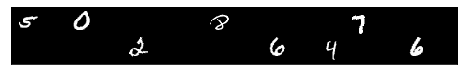

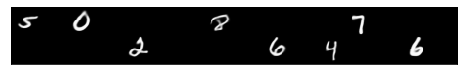

Epoch: 35 Iter: 8239 Loss: 0.03384 Recon Loss 0.025929 KL: 0.079107 N codes used: 32
Epoch: 35 Iter: 8279 Loss: 0.033967 Recon Loss 0.025883 KL: 0.080838 N codes used: 32
Epoch: 35 Iter: 8319 Loss: 0.033285 Recon Loss 0.025128 KL: 0.081568 N codes used: 32
Epoch: 35 Iter: 8359 Loss: 0.032903 Recon Loss 0.024645 KL: 0.082576 N codes used: 32
Epoch: 35 Iter: 8399 Loss: 0.03313 Recon Loss 0.025114 KL: 0.080158 N codes used: 32
Epoch: 35 Iter: 8439 Loss: 0.033291 Recon Loss 0.025253 KL: 0.080379 N codes used: 32
Epoch: 36 Iter: 8479 Loss: 0.033999 Recon Loss 0.024745 KL: 0.092542 N codes used: 32
Epoch: 36 Iter: 8519 Loss: 0.034581 Recon Loss 0.025946 KL: 0.086355 N codes used: 32
Epoch: 36 Iter: 8559 Loss: 0.033419 Recon Loss 0.025295 KL: 0.081234 N codes used: 32
Epoch: 36 Iter: 8599 Loss: 0.033559 Recon Loss 0.025469 KL: 0.080904 N codes used: 32
Epoch: 36 Iter: 8639 Loss: 0.034701 Recon Loss 0.025344 KL: 0.093574 N codes used: 32
Epoch: 36 Iter: 8679 Loss: 0.034461 Recon Loss 0.025594 

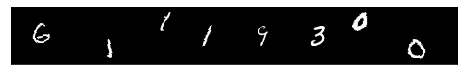

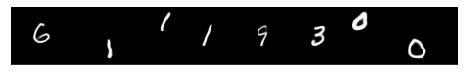

Epoch: 40 Iter: 9439 Loss: 0.033086 Recon Loss 0.024919 KL: 0.081668 N codes used: 32
Epoch: 40 Iter: 9479 Loss: 0.033309 Recon Loss 0.025147 KL: 0.081617 N codes used: 32
Epoch: 40 Iter: 9519 Loss: 0.033687 Recon Loss 0.024971 KL: 0.087167 N codes used: 32
Epoch: 40 Iter: 9559 Loss: 0.033047 Recon Loss 0.024844 KL: 0.082032 N codes used: 32
Epoch: 40 Iter: 9599 Loss: 0.032957 Recon Loss 0.024736 KL: 0.082214 N codes used: 32
Epoch: 41 Iter: 9639 Loss: 0.034424 Recon Loss 0.02553 KL: 0.08894 N codes used: 32
Epoch: 41 Iter: 9679 Loss: 0.033749 Recon Loss 0.025424 KL: 0.083245 N codes used: 32
Epoch: 41 Iter: 9719 Loss: 0.033014 Recon Loss 0.024853 KL: 0.08161 N codes used: 32
Epoch: 41 Iter: 9759 Loss: 0.032845 Recon Loss 0.024872 KL: 0.079738 N codes used: 32
Epoch: 41 Iter: 9799 Loss: 0.033461 Recon Loss 0.025618 KL: 0.078429 N codes used: 32
Epoch: 41 Iter: 9839 Loss: 0.032388 Recon Loss 0.02475 KL: 0.07638 N codes used: 32
Epoch: 42 Iter: 9879 Loss: 0.033949 Recon Loss 0.025552 KL:

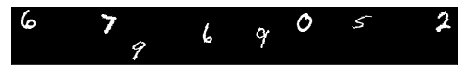

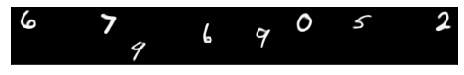

Epoch: 45 Iter: 10599 Loss: 0.032337 Recon Loss 0.024451 KL: 0.078858 N codes used: 32
Epoch: 45 Iter: 10639 Loss: 0.032286 Recon Loss 0.024816 KL: 0.074692 N codes used: 32
Epoch: 45 Iter: 10679 Loss: 0.03341 Recon Loss 0.025298 KL: 0.081118 N codes used: 32
Epoch: 45 Iter: 10719 Loss: 0.032948 Recon Loss 0.024718 KL: 0.082297 N codes used: 32
Epoch: 45 Iter: 10759 Loss: 0.031946 Recon Loss 0.024307 KL: 0.076385 N codes used: 32
Epoch: 45 Iter: 10799 Loss: 0.031534 Recon Loss 0.023624 KL: 0.079096 N codes used: 32
Epoch: 46 Iter: 10839 Loss: 0.032304 Recon Loss 0.02432 KL: 0.079842 N codes used: 32
Epoch: 46 Iter: 10879 Loss: 0.032356 Recon Loss 0.024599 KL: 0.077569 N codes used: 32
Epoch: 46 Iter: 10919 Loss: 0.031846 Recon Loss 0.024346 KL: 0.075005 N codes used: 32
Epoch: 46 Iter: 10959 Loss: 0.031441 Recon Loss 0.024106 KL: 0.073356 N codes used: 32
Epoch: 46 Iter: 10999 Loss: 0.03172 Recon Loss 0.024158 KL: 0.075627 N codes used: 32
Epoch: 46 Iter: 11039 Loss: 0.0321 Recon Loss 

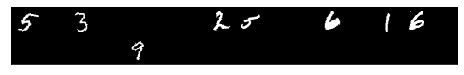

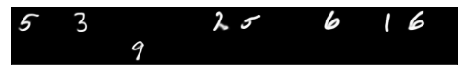

Epoch: 50 Iter: 11759 Loss: 0.033071 Recon Loss 0.024608 KL: 0.084625 N codes used: 32
Epoch: 50 Iter: 11799 Loss: 0.031923 Recon Loss 0.024027 KL: 0.078961 N codes used: 32
Epoch: 50 Iter: 11839 Loss: 0.033068 Recon Loss 0.025299 KL: 0.077693 N codes used: 32
Epoch: 50 Iter: 11879 Loss: 0.033209 Recon Loss 0.025313 KL: 0.07896 N codes used: 32
Epoch: 50 Iter: 11919 Loss: 0.0353 Recon Loss 0.026251 KL: 0.090483 N codes used: 32
Epoch: 50 Iter: 11959 Loss: 0.033676 Recon Loss 0.025541 KL: 0.081351 N codes used: 32
Epoch: 51 Iter: 11999 Loss: 0.033725 Recon Loss 0.02563 KL: 0.080952 N codes used: 32
Epoch: 51 Iter: 12039 Loss: 0.033851 Recon Loss 0.025833 KL: 0.080182 N codes used: 32
Epoch: 51 Iter: 12079 Loss: 0.032542 Recon Loss 0.02473 KL: 0.078118 N codes used: 32
Epoch: 51 Iter: 12119 Loss: 0.032755 Recon Loss 0.024971 KL: 0.077834 N codes used: 32
Epoch: 51 Iter: 12159 Loss: 0.032273 Recon Loss 0.024748 KL: 0.07525 N codes used: 32
Epoch: 51 Iter: 12199 Loss: 0.032122 Recon Loss 0

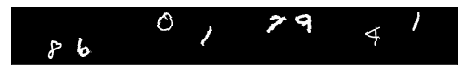

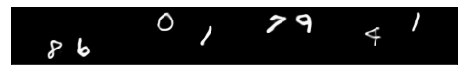

Epoch: 55 Iter: 12959 Loss: 0.033154 Recon Loss 0.025153 KL: 0.080012 N codes used: 32
Epoch: 55 Iter: 12999 Loss: 0.032214 Recon Loss 0.02426 KL: 0.079542 N codes used: 32
Epoch: 55 Iter: 13039 Loss: 0.032139 Recon Loss 0.02391 KL: 0.082285 N codes used: 32
Epoch: 55 Iter: 13079 Loss: 0.032597 Recon Loss 0.024805 KL: 0.077916 N codes used: 32
Epoch: 55 Iter: 13119 Loss: 0.033872 Recon Loss 0.025112 KL: 0.087594 N codes used: 32
Epoch: 55 Iter: 13159 Loss: 0.031528 Recon Loss 0.023646 KL: 0.078823 N codes used: 32
Epoch: 56 Iter: 13199 Loss: 0.031782 Recon Loss 0.023674 KL: 0.081083 N codes used: 32
Epoch: 56 Iter: 13239 Loss: 0.032708 Recon Loss 0.025088 KL: 0.076203 N codes used: 32
Epoch: 56 Iter: 13279 Loss: 0.032193 Recon Loss 0.02436 KL: 0.078331 N codes used: 32
Epoch: 56 Iter: 13319 Loss: 0.031507 Recon Loss 0.023637 KL: 0.078706 N codes used: 32
Epoch: 56 Iter: 13359 Loss: 0.03153 Recon Loss 0.023986 KL: 0.075439 N codes used: 32
Epoch: 57 Iter: 13399 Loss: 0.031856 Recon Loss

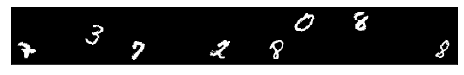

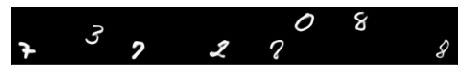

In [6]:
print("Device in use: {}".format(CONFIG.DEVICE))

loss_history = []
recon_loss_history = []
kl_loss_history = []
n_used_codes_history = []
kl_weight_history = []
temp_history = []

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, _ in train_loader:
        x = x.to(CONFIG.DEVICE)

        optimizer.zero_grad()

        temp = temp_annealer.step(iteration)
        x_recon, z_logits, z = model(x, temp)

        recon_loss = F.binary_cross_entropy(x_recon, x)

        kld_codes_loss = KLD_codes_uniform_loss(z)

        loss = recon_loss + 0.1 * kld_codes_loss

        # dist = Bernoulli(probs=x_recon)
        # recon_loss = - dist.log_prob((x > 0).float()).mean()

        # kld_loss = KLD_uniform_loss(z_logits)
        # kl_weight = kl_annealer.step(iteration)
        
        # loss = recon_loss + kl_weight * kld_loss

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            n_used_codes = len(z.detach().cpu().argmax(dim=1).view(-1).unique())
            if (iteration + 1) % 40 == 0:
                print("Epoch: {} Iter: {} Loss: {} Recon Loss {} KL: {} N codes used: {}".format(
                    epoch, iteration, 
                    round(loss.item(), 6), 
                    round(recon_loss.item(), 6), 
                    round(kld_codes_loss.item(), 6), 
                    round(n_used_codes, 6)
                ))
        
        loss_history.append(loss.item())
        recon_loss_history.append(recon_loss.item())
        # kl_loss_history.append(kld_loss.item())
        # kl_weight_history.append(kl_weight)
        temp_history.append(temp)
        n_used_codes_history.append(n_used_codes)
        
        iteration += 1
    
    if (epoch + 1) % 5 == 0:
        print("====== Epoch {} ======".format(epoch))
        img_grid = make_grid(x[:8, :, :, :].detach().cpu())
        show(img_grid)
        img_recon_grid = make_grid(x_recon[:8, :, :, :].detach().cpu())
        show(img_recon_grid)
        print("======================")


In [8]:
model.save_model(root_path=CONFIG.dvae_path, model_name=CONFIG.dvae_model_name)

# torch.save(model.encoder.state_dict(), "./gdrive/MyDrive/Colab Notebooks/thesis/dvae_M_mnist_encoder.pth")
# torch.save(model.decoder.state_dict(), "./gdrive/MyDrive/Colab Notebooks/thesis/dvae_M_mnist_decoder.pth")

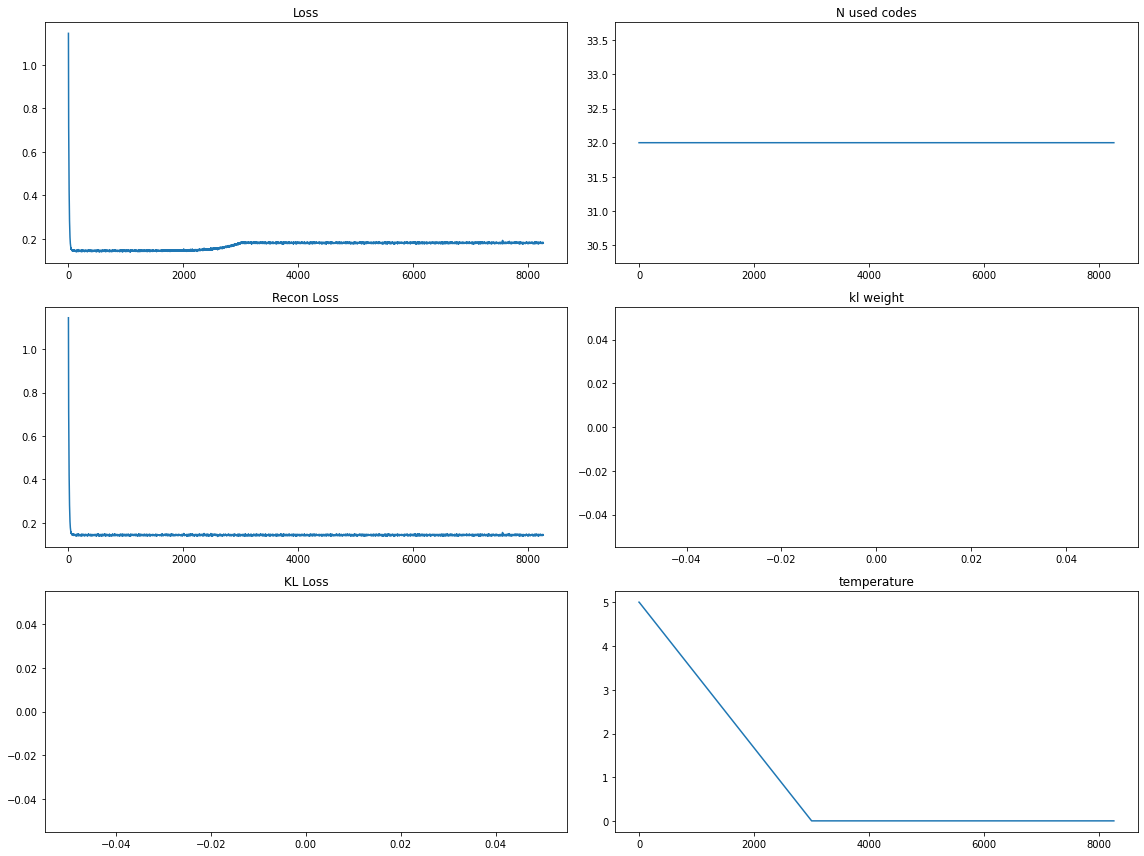

In [9]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(loss_history)
plt.title("Loss")

plt.subplot(3, 2, 3)
plt.plot(recon_loss_history)
plt.title("Recon Loss")

plt.subplot(3, 2, 5)
plt.plot(kl_loss_history)
plt.title("KL Loss")

plt.subplot(3, 2, 2)
plt.plot(n_used_codes_history)
plt.title("N used codes")

plt.subplot(3, 2, 4)
plt.plot(kl_weight_history)
plt.title("kl weight")

plt.subplot(3, 2, 6)
plt.plot(temp_history)
plt.title("temperature")

plt.tight_layout()
plt.show()

In [17]:
1024 / 4

256.0